## Imports

In [ ]:
import tensorflow as tf
import os
import random
import shutil
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

import sklearn.metrics as sm
import seaborn as sns

## Data wrangling (setting up the train, test, val generators etc.)

In [ ]:
def get_data():
    !wget 'https://drive.google.com/uc?id=1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL&export=download'
    os.rename(os.listdir('/content/')[1], 'kaggle.json')
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

    import kaggle

    ! kaggle datasets download -d ciplab/real-and-fake-face-detection
    try:
        from zipfile import ZipFile
    except ImportError:
        return
    
    fname = "/content/real-and-fake-face-detection.zip"

    with ZipFile(fname,'r') as zip:
        zip.extractall()

    # delete the extra folder
    ! rm /content/real_and_fake_face_detection/ -r
    
    print('Done Extracting data')


In [ ]:
get_data()

--2022-11-13 16:23:17--  https://drive.google.com/uc?id=1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL&export=download
Resolving drive.google.com (drive.google.com)... 209.85.234.102, 209.85.234.139, 209.85.234.100, ...
Connecting to drive.google.com (drive.google.com)|209.85.234.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eh37i9kqmukqbf7vnbhap4prtsmrhfev/1668356550000/13257672939726536336/*/1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL?e=download&uuid=f1b9c104-6c3a-43e3-a6ac-14d10d883b6a [following]
--2022-11-13 16:23:17--  https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eh37i9kqmukqbf7vnbhap4prtsmrhfev/1668356550000/13257672939726536336/*/1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL?e=download&uuid=f1b9c104-6c3a-43e3-a6ac-14d10d883b6a
Resolving doc-0k-1c-docs.googleusercontent.com (doc-0k-1c-docs.googleusercontent.com)... 108.177.121.132, 2607

How much data do we have to deal with?

In [ ]:
print(f'Total FAKE samples: {len(os.listdir("/content/real_and_fake_face/training_fake"))}')
print(f'Total REAL samples: {len(os.listdir("/content/real_and_fake_face/training_real"))}')


Total FAKE samples: 960
Total REAL samples: 1081


Making train, val and test data
> So currently all the data is in the training_fake and training_real folder. So here's what we need to do:

1. Make another dir called Data
2. Make sub-dir 'Train' 'Val' and 'Test'
3. Within those sub-dir there needs to be 'Fake' and 'Real' folders consisting of data from fake and real images

In [ ]:
def train_test_val():
    path='Data/'

    #if files already exist, remove all the data in them
    try:
        os.mkdir('Data/')
    except FileExistsError:
        !rm 'Data/' -r
    
    !mkdir 'Data/'
    !mkdir 'Data/Train/'
    !mkdir 'Data/Train/Fake/'
    !mkdir 'Data/Train/Real/'
    !mkdir 'Data/Test/'
    !mkdir 'Data/Test/Fake/'
    !mkdir 'Data/Test/Real/'
    !mkdir 'Data/Val/'
    !mkdir 'Data/Val/Fake/'
    !mkdir 'Data/Val/Real/'


    # Now need to move files around
    # We'll use a 70 15 15 split, 70% training data, 15% validation data, 15% testing data
    
    # Fake
    src_fake = '/content/real_and_fake_face/training_fake/'
    dst_train_fake = '/content/Data/Train/Fake/'
    dst_test_fake = '/content/Data/Test/Fake/'
    dst_val_fake = '/content/Data/Val/Fake/'

    #so there are 960 total images that are fake, so 70% of that is 672
    # 15% of 960 is 144
    # So for list slicing our training fake data will be 0:672
    # our test fake data will be 673:816
    # and our val fake data will be 817:

    fake_imgs = os.listdir(src_fake)
    np.random.shuffle(fake_imgs)
    
    train_fake_imgs = fake_imgs[0:672] #70%
    test_fake_imgs = fake_imgs[673:816] #~15%
    val_fake_imgs = fake_imgs[817:] #~15%
    
    # Real
    src_real = '/content/real_and_fake_face/training_real/'
    dst_train_real = '/content/Data/Train/Real/'
    dst_test_real = '/content/Data/Test/Real/'
    dst_val_real = '/content/Data/Val/Real/'

    # so there is 1081 real images in training_real folder. so 70% of that is 757
    # 324 of that is reamining, and we split it equally (15% and 15%) meaning 162 and 162 will be
    # for validation and test sets.
    # 757 + 162 + 162 = 1081
    # 0:756 will be train
    # 757:919 will be val
    # 919: will be test

    real_imgs = os.listdir(src_real)
    np.random.shuffle(real_imgs)

    train_real_imgs = real_imgs[0:756] #70%
    test_real_imgs = real_imgs[757:919] #15%
    val_real_imgs = real_imgs[919:] #15%

    # using shutil.move()
    print('Moving real images...')
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_train_real, file)) for file in train_real_imgs]
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_test_real, file)) for file in test_real_imgs]
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_val_real, file)) for file in val_real_imgs]
    print('Done moving real imgs')

    print('Moving fake imgs...')
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_train_fake, file)) for file in train_fake_imgs]
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_test_fake, file)) for file in test_fake_imgs]
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_val_fake, file)) for file in val_fake_imgs]
    print('Done moving fake imgs')

    print(f'Size of train fake dir: {len(os.listdir(dst_train_fake))}')
    print(f'Size of test fake dir: {len(os.listdir(dst_test_fake))}')
    print(f'Size of val fake dir: {len(os.listdir(dst_val_fake))}')
    print(f'Size of train real dir: {len(os.listdir(dst_train_real))}')
    print(f'Size of test real dir: {len(os.listdir(dst_test_real))}')
    print(f'Size of val real dir: {len(os.listdir(dst_val_real))}')

    # remove empty folder now
    ! rm /content/real_and_fake_face -r


In [ ]:
train_test_val()

mkdir: cannot create directory ‘Data/’: File exists
Moving real images...
Done moving real imgs
Moving fake imgs...
Done moving fake imgs
Size of train fake dir: 672
Size of test fake dir: 143
Size of val fake dir: 143
Size of train real dir: 756
Size of test real dir: 162
Size of val real dir: 162


#### Now we need to set-up the train, val, and test generators

In [ ]:
train_dir = '/content/Data/Train/'
test_dir = '/content/Data/Test/'
val_dir = '/content/Data/Val/'

img_dim = 150
batch_size = 32
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # training data


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_dim, img_dim),
    batch_size=1,
    class_mode='binary') # testing data


val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # training data

Found 1428 images belonging to 2 classes.
Found 305 images belonging to 2 classes.
Found 305 images belonging to 2 classes.


In [ ]:
def confusion_matrix_balanced_acc(y_true, y_preds):

  cnfmtrx = sm.confusion_matrix(y_true=y_true, y_pred=y_preds)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cnfmtrx.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cnfmtrx.flatten()/np.sum(cnfmtrx)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cnfmtrx, annot=labels, fmt='', cmap='Blues')
  
  print(f'Balanced Accuracy Score: {sm.balanced_accuracy_score(y_true, y_preds)}')


## Conv net

In [ ]:
#Imports
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt

In [ ]:
def model_init():
    img_dim = 150
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(img_dim, img_dim, 3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(rate=0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))

    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

In [ ]:
model = model_init()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                        

In [ ]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Train the network
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=round(train_generator.samples/train_generator.batch_size),
    epochs=10,
    validation_data=val_generator,
    validation_steps=round(val_generator.samples/val_generator.batch_size),
    # verbose=0
    # workers = 10,use_multiprocessing=True)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/15
45/45 [==============================] - 29s 414ms/step - loss: 1.1002 - acc: 0.5042 - val_loss: 0.6913 - val_acc: 0.5311
Epoch 2/15
45/45 [==============================] - 18s 410ms/step - loss: 0.6940 - acc: 0.5343 - val_loss: 0.6918 - val_acc: 0.5311
Epoch 3/15
45/45 [==============================] - 18s 405ms/step - loss: 0.6902 - acc: 0.5378 - val_loss: 0.6913 - val_acc: 0.5311
Epoch 4/15
45/45 [==============================] - 18s 407ms/step - loss: 0.6910 - acc: 0.5385 - val_loss: 0.6911 - val_acc: 0.5311
Epoch 5/15
45/45 [==============================] - 18s 405ms/step - loss: 0.6856 - acc: 0.5392 - val_loss: 0.6912 - val_acc: 0.5311
Epoch 6/15
45/45 [==============================] - 18s 407ms/step - loss: 0.6803 - acc: 0.5490 - val_loss: 0.7180 - val_acc: 0.5279
Epoch 7/15
45/45 [==============================] - 18s 406ms/step - loss: 0.6794 - acc: 0.5658 - val_loss: 0.6904 - val_acc: 0.5410
Epoch 8/15
45/45 [==============================] - 18s 407ms/step - 

In [ ]:
# plotting function:
def generate_plots(history):
    #accuracies
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #loss curves
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

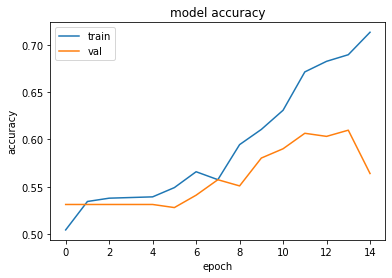

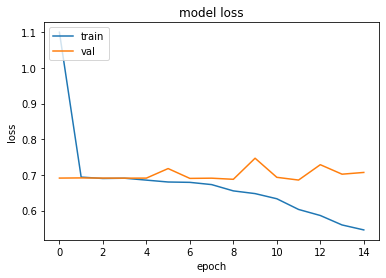

305/305 [==============================] - 4s 11ms/step - loss: 0.7453 - acc: 0.5770
Model test accuracy: 0.577049195766449
Model test loss: 0.7453098893165588


In [ ]:
generate_plots(history=history)
results = model.evaluate(test_generator, steps=round(test_generator.samples/test_generator.batch_size))
print(f'Model test accuracy: {results[1]}')
print(f'Model test loss: {results[0]}')

Tune the model and then re-train on all training data and evaluate on testing data. * NOTE: Skip a bunch of cells down for this, it'll say -- !Continuing from naive CNN! above the cell

In [ ]:
model = model.init()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Let's evaluate and get the confusion matrix and the balanced accuracy
num_test_samples = len(os.listdir('/content/Data/Test/Fake')) + len(os.listdir('/content/Data/Test/Real'))
y_preds_naivecnn = model.predict_generator(test_generator, steps=num_test_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Need to make y_true array
def curate_labels():
  y_train = []

# np_xtr = np.zeros(shape=(1633, 150, 150, 3))

  # print('Currently working on training data...')
  for root, dirs, files in os.walk('/content/Data/Test/', topdown=False):
      for name in files:
          if os.path.join(root,name).__contains__('Fake'):
              y_train.append(0.)
          else:
              y_train.append(1.)
  return np.asarray(y_train).squeeze()


In [ ]:
y_test_naive = curate_labels()

Threshold is set at 0.5

In [ ]:
def round_preds(y_preds_unrounded):
  return np.round(np.asarray(y_preds_unrounded)).squeeze()

Balanced Accuracy Score: 0.49002849002849


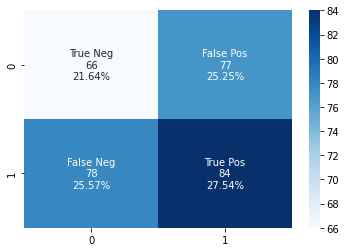

In [ ]:
y_preds_naivecnn = round_preds(y_preds_naivecnn)

confusion_matrix_balanced_acc(y_true=y_test_naive, y_preds=y_preds_naivecnn)

In [ ]:
model.save("garbage_cnn.h5")

#### K-fold cross val

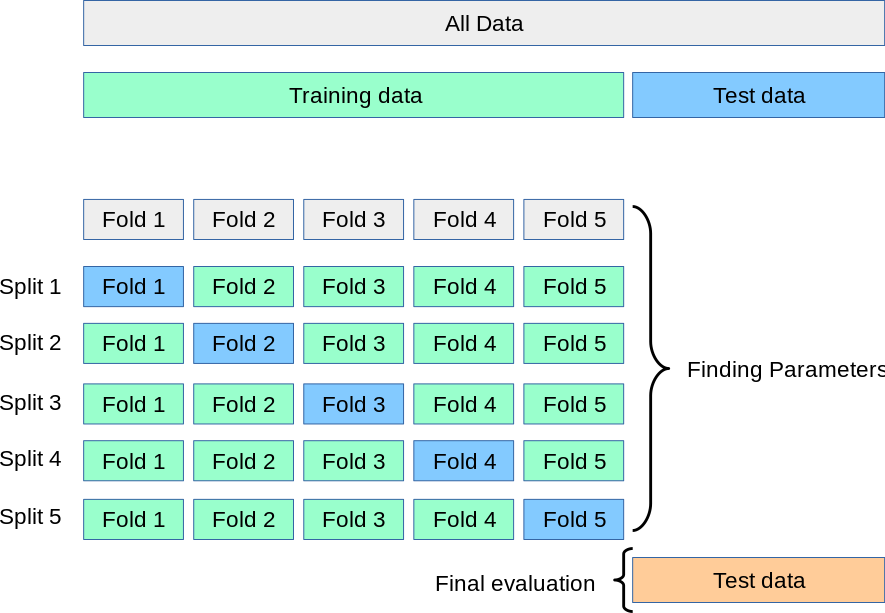

In [ ]:
from IPython import display
display.Image('/content/grid_search_cross_validation.png')

In [ ]:
get_data()

--2022-11-13 16:31:26--  https://drive.google.com/uc?id=1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL&export=download
Resolving drive.google.com (drive.google.com)... 209.85.234.138, 209.85.234.101, 209.85.234.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.234.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nfq3ucv9et9bdeg002d9paj24rjb6usp/1668357075000/13257672939726536336/*/1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL?e=download&uuid=346e51e5-1afd-42d2-8dbe-75112f96f2ae [following]
--2022-11-13 16:31:26--  https://doc-0k-1c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nfq3ucv9et9bdeg002d9paj24rjb6usp/1668357075000/13257672939726536336/*/1qD6YvLIrkCcb6xYROgRHB3aaP8q0V0IL?e=download&uuid=346e51e5-1afd-42d2-8dbe-75112f96f2ae
Resolving doc-0k-1c-docs.googleusercontent.com (doc-0k-1c-docs.googleusercontent.com)... 142.250.103.132, 2607

In [ ]:
def kfold_setup():
    
    path='Data/'

    #if files already exist, remove all the data in them
    try:
        os.mkdir('Data/')
    except FileExistsError:
        !rm 'Data/' -r
    
    !mkdir 'Data/'
    !mkdir 'Data/Train/'
    !mkdir 'Data/Train/Fake/'
    !mkdir 'Data/Train/Real/'
    !mkdir 'Data/Test/'
    !mkdir 'Data/Test/Fake/'
    !mkdir 'Data/Test/Real/'
    # !mkdir 'Data/Val/'
    # !mkdir 'Data/Val/Fake/'
    # !mkdir 'Data/Val/Real/'


    # Now need to move files around
    # We'll use a 80 20 split, with k-fold cross val
    
    # Fake
    src_fake = '/content/real_and_fake_face/training_fake/'
    dst_train_fake = '/content/Data/Train/Fake/'
    dst_test_fake = '/content/Data/Test/Fake/'

    #so there are 960 total images that are fake, so 80% of that is 768
    # 20% of 960 is 192

    # So for list slicing our training fake data will be 0:768
    # our test fake data will be 769:

    fake_imgs = os.listdir(src_fake)
    np.random.shuffle(fake_imgs)
    
    train_fake_imgs = fake_imgs[0:768] #80%
    test_fake_imgs = fake_imgs[769:] #~20%
    
    # Real
    src_real = '/content/real_and_fake_face/training_real/'
    dst_train_real = '/content/Data/Train/Real/'
    dst_test_real = '/content/Data/Test/Real/'

    # so there is 1081 real images in training_real folder. so 80% of that is 865
    # 0:865 will be train
    # 866: will be test

    real_imgs = os.listdir(src_real)
    np.random.shuffle(real_imgs)

    train_real_imgs = real_imgs[0:865] #80%
    test_real_imgs = real_imgs[866:] #20%

    # using shutil.move()
    print('Moving real images...')
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_train_real, file)) for file in train_real_imgs]
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_test_real, file)) for file in test_real_imgs]
    print('Done moving real imgs')

    print('Moving fake imgs...')
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_train_fake, file)) for file in train_fake_imgs]
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_test_fake, file)) for file in test_fake_imgs]
    print('Done moving fake imgs')

    print(f'Size of train fake dir: {len(os.listdir(dst_train_fake))}')
    print(f'Size of test fake dir: {len(os.listdir(dst_test_fake))}')
    print(f'Size of train real dir: {len(os.listdir(dst_train_real))}')
    print(f'Size of test real dir: {len(os.listdir(dst_test_real))}')

    # remove empty folder now
    ! rm /content/real_and_fake_face -r


In [ ]:
kfold_setup()

Moving real images...
Done moving real imgs
Moving fake imgs...
Done moving fake imgs
Size of train fake dir: 768
Size of test fake dir: 191
Size of train real dir: 865
Size of test real dir: 215


Now we need to train with k-fold cross val. So the way it will work is there are 4 folds. Meaning there will be 4 accuracies we will obtain. We need to first split up the training data 


In [ ]:
y_train = []
x_train = []
# np_xtr = np.zeros(shape=(1633, 150, 150, 3))

print('Currently working on training data...')
for root, dirs, files in os.walk('/content/Data/Train/', topdown=False):
    for name in files:
    
        if os.path.join(root,name).__contains__('Fake'):
            y_train.append(0.)
        else:
            y_train.append(1.)
        
        img = Image.open(os.path.join(root, name))

        x_train.append(np.asarray(img).astype('float32')/255.)
        # np_xtr[i] = np.asarray(img).astype('float32')/255.
        # print((np.asarray(img).astype('float32')/255.).shape)
        # np_xtr[i] = np.resize(np.asarray(img).astype('float32')/255., (150, 150, 3))
print('Finished training data...')

Currently working on training data...
Finished training data...


In [ ]:
y_test = []
x_test = []
# Repeating for test data
print('Working on testing data...')
for root, dirs, files in os.walk('/content/Data/Test/', topdown=False):
    for name in files:
        if os.path.join(root,name).__contains__('Fake'):
            y_test.append(0.)
        else:
            y_test.append(1.)

        img = Image.open(os.path.join(root, name))

        x_test.append(np.asarray(img).astype('float32')/255.)

print('Done')

Working on testing data...
Done


In [ ]:
print(f'y train size: {len(y_train)}')
print(f'x train size: {len(x_train)}')
print(f'y test size: {len(y_test)}')
print(f'x test size: {len(x_test)}')

y train size: 1633
x train size: 1633
y test size: 406
x test size: 406


In [ ]:
np_xtr = np.zeros((1633, 150, 150, 3))
np_xts = np.zeros((406, 150, 150, 3))
print('Working on X train')
for idx, el in enumerate(x_train):
    np_xtr[idx] = np.resize(el, (150, 150, 3))

print('Done-.. Working on X test now')
for idx, el in enumerate(x_test):
    np_xts[idx] = np.resize(el, (150, 150, 3))
print('Done')


Working on X train
Done-.. Working on X test now
Done


In [ ]:
# # convert the labels to np arrays too
# y_train = np.asarray(y_train)
# y_test = np.array(y_test)

# print(f'Y train shape: {y_train.shape}')
# print(f'Y test shape: {y_test.shape}')

X_train = x_train
X_test_final = x_test # capitalizing for consistency
y_test_final = y_test


## !Continuing from naive CNN –– concatenating training and val data, tuning params and re-running!

In [ ]:
y_train[0:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

We need to shuffle in unison first since it's all 1s and then 0s

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(np_xtr, np.asarray(y_train))
X_test, y_test = unison_shuffled_copies(np_xts, np.asarray(y_test))

In [ ]:
model = model_init()

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=.000085), metrics=['acc'])

hist = model.fit(X_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
103/103 [==============================] - 1s 6ms/step - loss: 0.7303 - acc: 0.5321
Epoch 2/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6826 - acc: 0.5707
Epoch 3/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6757 - acc: 0.5683
Epoch 4/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6624 - acc: 0.5897
Epoch 5/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6611 - acc: 0.6093
Epoch 6/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6423 - acc: 0.6197
Epoch 7/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6280 - acc: 0.6442
Epoch 8/10
103/103 [==============================] - 1s 6ms/step - loss: 0.6150 - acc: 0.6565
Epoch 9/10
103/103 [==============================] - 1s 6ms/step - loss: 0.5802 - acc: 0.6981
Epoch 10/10
103/103 [==============================] - 1s 6ms/step - loss: 0.5754 - acc: 0.6908


Evaluate the performance

In [ ]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: 0.7449 - acc: 0.5591


[0.7449138760566711, 0.5591133236885071]

Not bad. Let's make predictions and then get a confusion matrix and balanced accuracy score

13/13 [==============================] - 0s 4ms/step
Balanced Accuracy Score: 0.5100815779861196


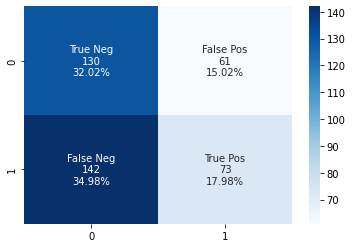

In [ ]:
y_preds = model.predict(X_test)

confusion_matrix_balanced_acc(y_true=y_test, y_preds=round_preds(y_preds))

Now we can run the k-fold cross val

In [ ]:
# K = 4
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True)

kf.get_n_splits(X_train, y_train)

4

In [ ]:
accs = []
loss = []

for train_index, test_index in kf.split(X_train):
    # print(f'TRAIN: {train_index}\nTrain shape: {len(train_index)}')
    # print(f'TEST: {test_index}\nTest shape: {len(test_index)}')

    X_train_fold = np.take(np_xtr, indices=train_index, axis=0)
    X_test_fold = np.take(np_xtr, indices=test_index, axis=0)

    y_train_fold = np.take(y_train, indices=train_index)
    y_test_fold = np.take(y_train, indices=test_index)
    # X_train_fold = [np.resize(X_train[i], new_shape=(150, 150, 3)) for i in train_index]
    # X_test_fold = [np.resize(X_train[i], new_shape=(150, 150,3)) for  i in test_index]

    # y_train_fold = [y_train[i] for i in train_index]
    # y_test_fold = [y_train[i] for i in test_index]

    model = model_init() # instantiate model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) # compile

    model.fit(X_train_fold, y_train_fold, batch_size=64, epochs=20)

    res = model.evaluate(X_test_fold, y_test_fold)
    
    accs.append(res[1])
    loss.append(res[0])

    print('Completed fold... Onto the next')

print('Done')

Epoch 1/20
20/20 [==============================] - 1s 16ms/step - loss: 1.3113 - acc: 0.4853
Epoch 2/20
20/20 [==============================] - 0s 17ms/step - loss: 0.6931 - acc: 0.5155
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6929 - acc: 0.5351
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6907 - acc: 0.5482
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6912 - acc: 0.5515
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6903 - acc: 0.5376
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6873 - acc: 0.5703
Epoch 8/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6883 - acc: 0.5564
Epoch 9/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6855 - acc: 0.5670
Epoch 10/20
20/20 [==============================] - 0s 16ms/step - loss: 0.6839 - acc: 0.5621
Epoch 11/20
20/20 [==============================] - 0s 16m

In [ ]:
print(f' Mean k-fold accuracy: {np.round(np.mean(accs), 3)}')
print(f' Mean k-fold loss: {np.round(np.mean(loss), 3)}')

 Mean k-fold accuracy: 0.542
 Mean k-fold loss: 0.689


## Additional baselines classifer


#### Random Classifier

In [ ]:
y_test = np.asarray(y_test)
random_accs = []

#stimulating 100 times a random classifier
for _ in range(0, 100):
  y_preds = np.random.randint(low=0, high=2, size=y_test.shape)
  acc = sm.accuracy_score(y_true=y_test, y_pred=y_preds)
  random_accs.append(np.round(acc, 3))

print(f'Mean random classifier accuracy over 100 trials: {np.round(np.mean(random_accs), 3)}')

Mean random classifier accuracy over 100 trials: 0.499


Random classifier

Balanced Accuracy Score: 0.4835748204066723


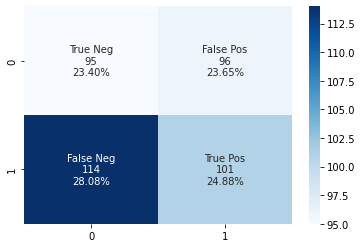

In [ ]:
confusion_matrix_balanced_acc(y_true=y_test, y_preds=np.random.randint(low=0, high=2, size=y_test.shape))